#### DRAFT ####
My overall strategy for this challenge is as follows:
1. Clean data
> a. Observe missing values <br>
> b. Figure out whether to drop or impute <br>
> c. What type of imputation to do

2. EDA
> a. Scatter plots between key variables <br>
> b. Correlations (which are strongest?) <br>
> c. Of the strongest, selecting top correlations w/ absolute val >= .70 <br>
> d. Compare those w/ featurewiz library 

3. Modeling & Evaluation
> a. 2 models: (1 with my selected features (top 0.50 and above) + (models w/ LASSO) <br>
> b. train/test/split training dataset for both models <br>
> c. Metrics --> (R2, RMSE) 

4. Conclusion & Submitting Best Model

### Part I: Imports, Reading Data, Basic Info

In [2]:
# imports! 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# more imports!
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression # model for linear reg 
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV # model for lasso & ridge
from sklearn.metrics import r2_score, mean_squared_error # metrics for evaluation
from sklearn.preprocessing import StandardScaler # for scaling data

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# reading training and test data
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')

# goal: clean both datasets together, keep 'test' set away from 'train' to prevent data leakage, don't learn anything from test set

In [4]:
# dimensions of train, test
print(f"Original Train: {df_train.shape}")
print(f"Original Test: {df_test.shape}")

# as expected, test is 1 column shy (saleprice outcome)
# also, it appears train/test have roughly been split 70/30
print("Data has been split roughly 70/30, train/test")

Original Train: (2051, 81)
Original Test: (878, 80)
Data has been split roughly 70/30, train/test


---

### Part II: Data Cleaning

First, let's observe what data we have: Numerical vs. Categorical.

In [5]:
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [6]:
# sigh, had to use ChatGPT already
numerical = list(df_train.select_dtypes(exclude = 'object').columns)
categorical = list(df_train.select_dtypes(include = 'object').columns)

#### All Categorical Variables: 
['MS Zoning',
 'Street',
 'Alley',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Central Air',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Fireplace Qu',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive',
 'Pool QC',
 'Fence',
 'Misc Feature',
 'Sale Type']

I used: **df_train[categorical].iloc[:5, start : stop]** to go through the columns and verify these should be categorical. They check out.

---

#### All Numerical Variables: 
['Id',
 'PID',
 'MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold',
 'SalePrice']
 
 

Again, I used: **df_train[numerical].iloc[:5, start : stop]** to go through the columns and verify if these should be numerical. Notes below!

***Don't make sense as numerical*** <br>
['Id', 'PID', ]

***Change to int (don't make sense as float)*** <br>
However, these have NaN values, so I will impute the missing values first before converting both to integer. (Later) <br>
['Garage Yr Blt', 'Garage Cars']

In [12]:
# Let's convert Id & PID to 'object' type

# First, check if there are any np.nan values in 'Id'
print(f"Np.nan in 'Id': {np.nan in df_train['Id'].value_counts().index}")
print(f"Np.nan in 'PID': {np.nan in df_train['PID'].value_counts().index}")

Np.nan in 'Id': False
Np.nan in 'PID': False


In [13]:
# Great, now I can convert both
df_train['Id'] = df_train['Id'].astype(object)
df_train['PID'] = df_train['PID'].astype(object)

# Now, recall Numerical & Categorical lists to update them
numerical = list(df_train.select_dtypes(exclude = 'object').columns)    # ID, PID removed
categorical = list(df_train.select_dtypes(include = 'object').columns)    # ID, PID added

---
#### Dealing with Missing Values
Here, I want to decide which variables have missing values and how many. If a ton of values are missing, it makes sense to drop the variable altogether. If there aren't too many missing values, it makes sense to impute the values so we can include them in our model (if necessary).

In [14]:
# hard to view which columns have how many missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   object 
 1   PID              2051 non-null   object 
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [15]:
df_train.isnull().sum()

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
               ... 
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
SalePrice         0
Length: 81, dtype: int64

In [16]:
# making a missing values DF
train_missing_vals = pd.DataFrame(df_train.isnull().mean(), columns = ['Avg. Missing']).sort_values(by = 'Avg. Missing', ascending = False)
train_missing_vals['Total Missing'] = df_train.isnull().sum()

# let's see which have missing values at all --> 26 total vars have missing values > 0
train_missing_vals[train_missing_vals['Avg. Missing'] > 0]

,Avg. Missing,Total Missing
Pool QC,0.995612,2042
Misc Feature,0.968308,1986
Alley,0.931741,1911
Fence,0.804973,1651
Fireplace Qu,0.487567,1000
Lot Frontage,0.160897,330
Garage Finish,0.055583,114
Garage Qual,0.055583,114
Garage Yr Blt,0.055583,114
Garage Cond,0.055583,114


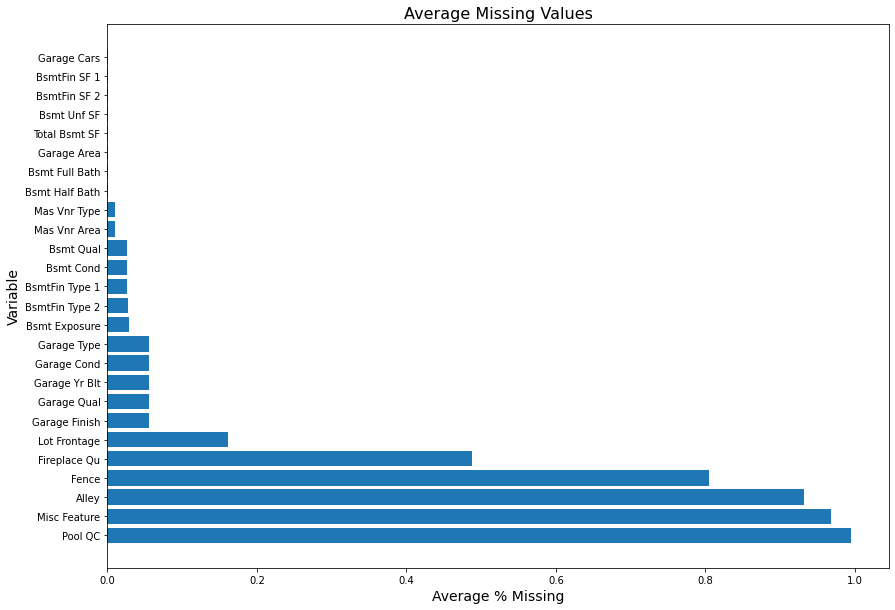

In [17]:
# graphing the number of missing values
plt.figure(figsize = (14,10))
plt.barh(y = train_missing_vals[train_missing_vals['Avg. Missing'] > 0].index, width = train_missing_vals[train_missing_vals['Avg. Missing'] > 0]['Avg. Missing'])
plt.title('Average Missing Values', size = 16)
plt.ylabel('Variable', size = 14)
plt.xlabel('Average % Missing', size = 14);

# saving
plt.savefig('./project2_graphs/missing_vals.pdf')

Based on the chart, it makes sense to drop: **['Fireplace Qu', 'Fence', 'Alley', 'Misc Feature', 'Pool QC'].** <br>
For the rest, we can impute missing values using mean, median, or mode.

In [18]:
#### MAJOR ALTERATION OF KEY DATAFRAME ####

# Dropping ['Fireplace Qu', 'Fence', 'Alley', 'Misc Feature', 'Pool QC'] from df_train

df_train.drop(columns = ['Fireplace Qu', 'Fence', 'Alley', 'Misc Feature', 'Pool QC'], inplace = True)

In [19]:
# Verifying: 5 fewer columns
df_train.shape

(2051, 76)

In [20]:
# let's add another column to represent the type of variable
train_missing_vals['Var Type'] = ['numerical' if i in numerical else 'categorical' for i in train_missing_vals.index ]

# these are the variables we need to do some imputations for
impute_vars = train_missing_vals[(train_missing_vals['Avg. Missing'] > 0) & (train_missing_vals['Avg. Missing'] < 0.4)]

In [21]:
impute_vars

,Avg. Missing,Total Missing,Var Type
Lot Frontage,0.160897,330,numerical
Garage Finish,0.055583,114,categorical
Garage Qual,0.055583,114,categorical
Garage Yr Blt,0.055583,114,numerical
Garage Cond,0.055583,114,categorical
Garage Type,0.055095,113,categorical
Bsmt Exposure,0.028279,58,categorical
BsmtFin Type 2,0.027304,56,categorical
BsmtFin Type 1,0.026816,55,categorical
Bsmt Cond,0.026816,55,categorical


#### Imputing Categorical Variables
For the categorical ones, I'll use the **mode** to fill in the missing values. First, I'll test it on one (with inplace = False). After confirming my code works, I will write a loop to go through **all** categorical vars in ***impute_vars*** dataframe.

In [22]:
# This whole test is just me testing the imputation using mode for 'Garage Finish' (a categorical var)
print(f"Before Impute: {df_train['Garage Finish'].value_counts()[0]}")
print(f"After Impute: {df_train['Garage Finish'].fillna(value = df_train['Garage Finish'].mode()[0]).value_counts()[0]}")

print("The count for 'Unf' went up by 114. There were 114 missing values for this variable, so this implies that our imputation using mode works. Noice. 😎")

Before Impute: 849
After Impute: 963
The count for 'Unf' went up by 114. There were 114 missing values for this variable, so this implies that our imputation using mode works. Noice. 😎


In [23]:
# Now, let's apply the above to ALL categorical variables that need imputing using the 'for' loop I wrote below:

for i, val in impute_vars['Var Type'].iteritems():    # Shoutout ChatGPT for .iteritems()
    if val == 'categorical':
        df_train[i].fillna(value = df_train[i].mode()[0], inplace = True)

In [24]:
# Testing!
df_train['Garage Qual'].isna().sum()    # missing values taken care of

0

#### Imputing Numerical Variables
This will be more tricky, since I want to first decide whether to use the mean or median. From my stats classes, I remember that typically a variable is about normal if the mean is equal to the median and mode. <br> 
To determine whether to use mean or median, I will calculate the **skewness** for each numerical value. <br>
Per "https://community.gooddata.com/metrics-and-maql-kb-articles-43/normality-testing-skewness-and-kurtosis-241", skewness > 1 or < -1 indicates high level of skew, which could imply presence of outliers.
> 1. If skewness for the variable > 1 or < -1, I will impute with the median.
> 2. Otherwise, I'll use the mean.

In [25]:
# testing on 'Lot Frontage' variable w/out 'inplace = True'
df_train['Lot Frontage'].fillna(value = df_train['Lot Frontage'].mean()).isna().sum()

0

In [26]:
# Like before, let's apply the .fillna() to all numerical vars

for i, val in impute_vars['Var Type'].iteritems():
    if val == 'numerical':
        if abs(df_train[i].skew()) > 1: # highly skewed, impute w/ median
            df_train[i].fillna(value = df_train[i].median(), inplace = True)     
        else: # impute w/ mean
            df_train[i].fillna(value = df_train[i].mean(), inplace = True)

In [27]:
# Testing!
df_train.isna().sum().max()    # no more missing vals

0

In [28]:
# Lastly, I'll also drop ID & PID since these won't be necessary for my regressions
df_train.drop(columns = ['Id', 'PID'], inplace = True)

---

### Part III: Feature Processing & Engineering

In [29]:
df_train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,60,RL,68.0,13517,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,44,0,0,0,0,0,3,2010,WD,130500
1,60,RL,43.0,11492,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,...,74,0,0,0,0,0,4,2009,WD,220000
2,20,RL,68.0,7922,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,52,0,0,0,0,0,1,2010,WD,109000
3,60,RL,73.0,9802,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,4,2010,WD,174000
4,50,RL,82.0,14235,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,59,0,0,0,0,0,3,2010,WD,138500


In [30]:
# Since several changes have been made, I'll recall which variables are numerical vs. categorical
numerical = list(df_train.select_dtypes(exclude = 'object').columns)
categorical = list(df_train.select_dtypes(include = 'object').columns)

Before continuing, I will process some of the numerical columns first, and then move to the categorical columns.

#### Numerical

In [31]:
df_train[numerical].iloc[:5,:10]

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2
0,60,68.0,13517,6,8,1976,2005,289.0,533.0,0.0
1,60,43.0,11492,7,5,1996,1997,132.0,637.0,0.0
2,20,68.0,7922,5,7,1953,2007,0.0,731.0,0.0
3,60,73.0,9802,5,5,2006,2007,0.0,0.0,0.0
4,50,82.0,14235,6,8,1900,1993,0.0,0.0,0.0


In [32]:
# MS SubClass should be an 'object' instead
df_train['MS SubClass'].astype(object)

0       60
1       60
2       20
3       60
4       50
        ..
2046    20
2047    30
2048    50
2049    20
2050    60
Name: MS SubClass, Length: 2051, dtype: object

In [33]:
# making 'age' variables using year columns --> dataset collected in 2011, using 2011 as base
df_train['age'] = 2011 - df_train['Year Built']
df_train['sold_age'] = 2011 - df_train['Yr Sold']
df_train['remodel_age'] = 2011 - df_train['Year Remod/Add']
df_train['garage_age'] = 2011 - df_train['Garage Yr Blt']

In [34]:
# now, dropping the year columns
df_train.drop(columns = ['Year Built'], inplace = True)
df_train.drop(columns = ['Yr Sold'], inplace = True)
df_train.drop(columns = ['Year Remod/Add'], inplace = True)
df_train.drop(columns = ['Garage Yr Blt'], inplace = True)

In [35]:
# redefining numerical
numerical = list(df_train.select_dtypes(exclude = 'object').columns)

In [36]:
df_train[numerical].iloc[:5, 30:]

,Misc Val,Mo Sold,SalePrice,age,sold_age,remodel_age,garage_age
0,0,3,130500,35,1,6,35.0
1,0,4,220000,15,2,14,14.0
2,0,1,109000,58,1,4,58.0
3,0,4,174000,5,1,4,4.0
4,0,3,138500,111,1,18,54.0


In [37]:
# Creating Binary Variables for certain home features
# 1 = yes, 0 = no

# Basement? 
df_train['basement_binary'] = [1 if i > 0 else 0 for i in df_train['Total Bsmt SF'].values]

# Fireplace?
df_train['fireplace_binary'] = [1 if i > 0 else 0 for i in df_train['Fireplaces'].values]

# Garage?
df_train['garage_binary'] = [1 if i > 0 else 0 for i in df_train['Garage Area'].values]

# Wood Deck?
df_train['wooddeck_binary'] = [1 if i > 0 else 0 for i in df_train['Wood Deck SF'].values]

# TOTAL PORCH SQ_FT
df_train['total_porch_sqft'] = df_train['Open Porch SF'] + df_train['Enclosed Porch'] + df_train['3Ssn Porch'] + df_train['Screen Porch']

# Has porch? (any porch at all?)
df_train['porch_binary'] = [1 if i > 0 else 0 for i in df_train['total_porch_sqft'].values]

# Pool?
df_train['pool_binary'] = [1 if i > 0 else 0 for i in df_train['Pool Area'].values]

I made the above 7 variables to get a better sense of whether these features are actually present in the home or not, instead of representing every bit by numbers or square footage.

In [38]:
# redefining numerical
numerical = list(df_train.select_dtypes(exclude = 'object').columns)

#### Categorical

In [39]:
# go through the columns and observe (alter col index)
df_train[categorical].iloc[:5, 30:]

,Functional,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Sale Type
0,Typ,Attchd,RFn,TA,TA,Y,WD
1,Typ,Attchd,RFn,TA,TA,Y,WD
2,Typ,Detchd,Unf,TA,TA,Y,WD
3,Typ,BuiltIn,Fin,TA,TA,Y,WD
4,Typ,Detchd,Unf,TA,TA,N,WD


In [40]:
# binarize Central Air to 1 or 0 --> indicate whether house has central air
df_train['Central Air'].replace({'Y': 1, 'N': 0}, inplace = True)

In [41]:
# binarize Paved Drive to 1 or 0
df_train['Paved Drive'].replace({'Y' : 1, 'P' : 1, 'N' : 0}, inplace = True)

In [42]:
# renaming
df_train.rename(columns = {'Central Air' : 'air_binary', 'Paved Drive' : 'paved_binary'}, inplace = True)

In [43]:
# redefining categorical
categorical = list(df_train.select_dtypes(include = 'object').columns)

Binarizing the couple variables above would have made 2 new numerical vars. I will now redefine categorical, just to keep the list updated (like I did with numerical).

In [44]:
# new df_train dimensions
df_train.shape

(2051, 81)

Now, I will run **pd.get_dummies()** on my *categorical* variables!

In [45]:
# store into a NEW dataframe 
df_train_2 = pd.get_dummies(df_train, columns = categorical, drop_first = True)

df_train_2.shape

(2051, 239)

Great, now we have a ton of variables/features to work with. I will now move on to EDA to mostly perform correlation analysis and choose the best features.

---

### Part IV: Quick EDA & Feature Selection Set 1

**sqrt(2051) = ~ 45, target is to stay under 45 features**

In [46]:
corrs = pd.DataFrame(df_train_2.corr()['SalePrice']).sort_values(by = 'SalePrice', ascending = False)

In [47]:
# let's choose our first features by filtering abs(correlation) > 0.5
corrs[(abs(corrs['SalePrice']) > 0.5) & (corrs.index != 'SalePrice')]

,SalePrice
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650246
Garage Cars,0.648197
Total Bsmt SF,0.628754
1st Flr SF,0.618486
Full Bath,0.537969
Foundation_PConc,0.529047
TotRms AbvGrd,0.504014
Mas Vnr Area,0.503579


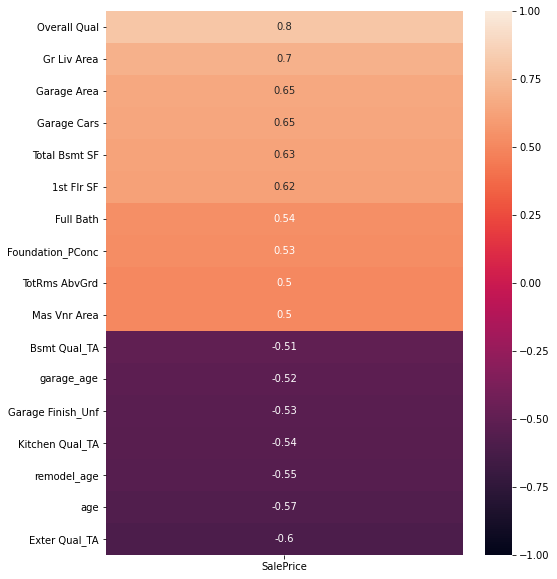

In [48]:
# let's plot a heatmap of correlations and visually see any that are abs() > 0.5
plt.figure(figsize = (8, 10))
sns.heatmap(corrs[(abs(corrs['SalePrice']) > 0.5) & (corrs.index != 'SalePrice')], vmin = -1, vmax = 1, annot = True);

In [67]:
# storing feature set 1 into a list
features_1 = list(corrs[(abs(corrs['SalePrice']) > 0.5) & (corrs.index != 'SalePrice')].index)

In [68]:
# However, this feature set contains dummy variables, some of which are missing their complementary dummies
# So, let's add them in as features
features_1

['Overall Qual',
 'Gr Liv Area',
 'Garage Area',
 'Garage Cars',
 'Total Bsmt SF',
 '1st Flr SF',
 'Full Bath',
 'Foundation_PConc',
 'TotRms AbvGrd',
 'Mas Vnr Area',
 'Bsmt Qual_TA',
 'garage_age',
 'Garage Finish_Unf',
 'Kitchen Qual_TA',
 'remodel_age',
 'age',
 'Exter Qual_TA']

In [69]:
for i in list(df_train_2.columns): 
    if 'Foundation_' in i:
        features_1.append(i)
    elif 'Bsmt Qual_' in i:
        features_1.append(i)
    elif 'Garage Finish_' in i:
        features_1.append(i)
    elif 'Kitchen Qual_' in i:
        features_1.append(i)
    elif 'Exter Qual_' in i:
        features_1.append(i)
    else:
        pass

In [85]:
# great, now we have a more full feature set #1
features_1

['Overall Qual',
 'Gr Liv Area',
 'Garage Area',
 'Garage Cars',
 'Total Bsmt SF',
 '1st Flr SF',
 'Full Bath',
 'Foundation_PConc',
 'TotRms AbvGrd',
 'Mas Vnr Area',
 'Bsmt Qual_TA',
 'garage_age',
 'Garage Finish_Unf',
 'Kitchen Qual_TA',
 'remodel_age',
 'age',
 'Exter Qual_TA',
 'Exter Qual_Fa',
 'Exter Qual_Gd',
 'Exter Qual_TA',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'Bsmt Qual_Fa',
 'Bsmt Qual_Gd',
 'Bsmt Qual_Po',
 'Bsmt Qual_TA',
 'Kitchen Qual_Fa',
 'Kitchen Qual_Gd',
 'Kitchen Qual_TA',
 'Garage Finish_RFn',
 'Garage Finish_Unf']

### Testing Feature Set 1 Performance

In [88]:
# Let's make X & y for this first round of performance testing
X_set1 = df_train_2[features_1]
y_set1 = df_train_2['SalePrice']

In [99]:
# train/test splits
X_set1_train, X_set1_test, y_set1_train, y_set1_test = train_test_split(X_set1, y_set1, test_size = 0.2, random_state = 42) # random_state for replicability

In [100]:
# Scaling the data
sc = StandardScaler()

# fit_transform the X_set1_train
Z_set1_train = sc.fit_transform(X_set1_train)

# just transform X_set1_test
Z_set1_test = sc.transform(X_set1_test)

#### 1. Model 1 - MLR

In [127]:
# instantiate model
model1_lr = LinearRegression()

# fit the model on transformed TRAIN data
model1_lr.fit(Z_set1_train, y_set1_train)

LinearRegression()

In [128]:
print(f"LinearRegression - Training Score: {round(model1_lr.score(Z_set1_train, y_set1_train), 4)}")
print(f"LinearRegression - Test Score: {round(model1_lr.score(Z_set1_test, y_set1_test), 4)}")

LinearRegression - Training Score: 0.827
LinearRegression - Test Score: 0.8738


These R2 scores seem encouraging, though I am a bit skeptical that the model performed better on the test set that it did on the training set. <br>
Since the data has been scaled, the coefficients aren't much use to us from an interpretability standpoint, so making inferences will be difficult. <br> 
However, the model may have some merit for predictive purposes.

In [137]:
# Now, let's predict y's using the testing set and observe the RMSE
y_set1_preds = model1_lr.predict(Z_set1_test)

In [141]:
# RMSE
mean_squared_error(y_set1_test, y_set1_preds, squared = False )

27377.863294855182

In [146]:
# storing evaluation metrics for this model
model1_lr_scores = {"Training": round(model1_lr.score(Z_set1_train, y_set1_train), 4),
                   "Test": round(model1_lr.score(Z_set1_test, y_set1_test), 4),
                   "RMSE": round(mean_squared_error(y_set1_test, y_set1_preds, squared = False ), 2)} 

# CLEANING UP THE TEST DATA CSV

In [150]:
### SETTING UP SAME CLEANING PROCESS FOR TEST.CSV ###

# sigh, had to use ChatGPT already
numerical_test = list(df_test.select_dtypes(exclude = 'object').columns)
categorical_test = list(df_test.select_dtypes(include = 'object').columns)


# Great, now I can convert both
df_test['Id'] = df_test['Id'].astype(object)
df_test['PID'] = df_test['PID'].astype(object)

# Now, recall Numerical & Categorical lists to update them
numerical_test = list(df_test.select_dtypes(exclude = 'object').columns)    # ID, PID removed
categorical_test = list(df_test.select_dtypes(include = 'object').columns)    # ID, PID added



# making a missing values DF
test_missing_vals = pd.DataFrame(df_test.isnull().mean(), columns = ['Avg. Missing']).sort_values(by = 'Avg. Missing', ascending = False)
test_missing_vals['Total Missing'] = df_test.isnull().sum()

# let's see which have missing values at all --> 26 total vars have missing values > 0
test_missing_vals[test_missing_vals['Avg. Missing'] > 0]



df_test.drop(columns = ['Fireplace Qu', 'Fence', 'Alley', 'Misc Feature', 'Pool QC'], inplace = True)


# let's add another column to represent the type of variable
test_missing_vals['Var Type'] = ['numerical' if i in numerical else 'categorical' for i in test_missing_vals.index ]

# these are the variables we need to do some imputations for
impute_vars_test = test_missing_vals[(test_missing_vals['Avg. Missing'] > 0) & (test_missing_vals['Avg. Missing'] < 0.4)]



for i, val in impute_vars_test['Var Type'].iteritems():    # Shoutout ChatGPT for .iteritems()
    if val == 'categorical':
        df_test[i].fillna(value = df_test[i].mode()[0], inplace = True)
        
        
        
for i, val in impute_vars['Var Type'].iteritems():
    if val == 'numerical':
        if abs(df_test[i].skew()) > 1: # highly skewed, impute w/ median
            df_test[i].fillna(value = df_test[i].median(), inplace = True)     
        else: # impute w/ mean
            df_test[i].fillna(value = df_test[i].mean(), inplace = True)
            
            
df_test.drop(columns = ['Id', 'PID'], inplace = True)



df_test['MS SubClass'].astype(object)


df_test['age'] = 2011 - df_test['Year Built']
df_test['sold_age'] = 2011 - df_test['Yr Sold']
df_test['remodel_age'] = 2011 - df_test['Year Remod/Add']
df_test['garage_age'] = 2011 - df_test['Garage Yr Blt']





df_test.drop(columns = ['Year Built'], inplace = True)
df_test.drop(columns = ['Yr Sold'], inplace = True)
df_test.drop(columns = ['Year Remod/Add'], inplace = True)
df_test.drop(columns = ['Garage Yr Blt'], inplace = True)







# Creating Binary Variables for certain home features
# 1 = yes, 0 = no

# Basement? 
df_test['basement_binary'] = [1 if i > 0 else 0 for i in df_test['Total Bsmt SF'].values]

# Fireplace?
df_test['fireplace_binary'] = [1 if i > 0 else 0 for i in df_test['Fireplaces'].values]

# Garage?
df_test['garage_binary'] = [1 if i > 0 else 0 for i in df_test['Garage Area'].values]

# Wood Deck?
df_test['wooddeck_binary'] = [1 if i > 0 else 0 for i in df_test['Wood Deck SF'].values]

# TOTAL PORCH SQ_FT
df_test['total_porch_sqft'] = df_test['Open Porch SF'] + df_test['Enclosed Porch'] + df_test['3Ssn Porch'] + df_test['Screen Porch']

# Has porch? (any porch at all?)
df_test['porch_binary'] = [1 if i > 0 else 0 for i in df_test['total_porch_sqft'].values]

# Pool?
df_test['pool_binary'] = [1 if i > 0 else 0 for i in df_test['Pool Area'].values]





df_test['Central Air'].replace({'Y': 1, 'N': 0}, inplace = True)
df_test['Paved Drive'].replace({'Y' : 1, 'P' : 1, 'N' : 0}, inplace = True)
df_test.rename(columns = {'Central Air' : 'air_binary', 'Paved Drive' : 'paved_binary'}, inplace = True)




KeyError: 'Id'

In [152]:
# redefine numerical and categorical for test
numerical_test = list(df_test.select_dtypes(exclude = 'object').columns)   
categorical_test = list(df_test.select_dtypes(include = 'object').columns) 

In [165]:
categorical_test

['MS Zoning',
 'Street',
 'Lot Shape',
 'Land Contour',
 'Utilities',
 'Lot Config',
 'Land Slope',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Exter Qual',
 'Exter Cond',
 'Foundation',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating',
 'Heating QC',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Garage Type',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Sale Type']

In [163]:
df_test_2 = pd.get_dummies(df_test, columns = categorical_test, drop_first = True)


In [164]:
df_test_2[list(df_train_2.columns)]

KeyError: "['SalePrice', 'MS Zoning_C (all)', 'Utilities_NoSeWa', 'Neighborhood_GrnHill', 'Neighborhood_Landmrk', 'Condition 2_Feedr', 'Condition 2_PosN', 'Condition 2_RRAe', 'Condition 2_RRAn', 'Condition 2_RRNn', 'Roof Matl_CompShg', 'Roof Matl_Membran', 'Exterior 1st_CBlock', 'Exterior 1st_ImStucc', 'Exterior 1st_Stone', 'Exterior 2nd_Stone', 'Bsmt Cond_Fa', 'Bsmt Cond_Po', 'Heating_OthW', 'Heating_Wall', 'Heating QC_Po', 'Electrical_Mix', 'Functional_Sal', 'Functional_Sev', 'Garage Qual_Fa'] not in index"

In [161]:
list(df_train_2.columns)

['MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'air_binary',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'paved_binary',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'SalePrice',
 'age',
 'sold_age',
 'remodel_age',
 'garage_age',
 'basement_binary',
 'fireplace_binary',
 'garage_binary',
 'wooddeck_binary',
 'total_porch_sqft',
 'porch_binary',
 'pool_binary',
 'MS Zoning_C (all)',
 'MS Zoning_FV',
 'MS Zoning_I (all)',
 'MS Zoning_RH',
 'MS Zoning_RL',
 'MS Zoning_RM',
 'Street_Pave',
 'Lot Shape_IR2',
 'Lot Shape_IR3',
 'Lot Shape_Reg',
 'Land Contour_HLS',
 'Land Contour_Low',
 'Land Contour_Lvl',
 